### Loading the libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime as dt
import time
from tqdm import tqdm
import math

# Introduction

In this homework we had to work with graphs, more specifically with the graph generated from all the interaction on the website [StackOverflow](https://stackoverflow.com/). First of all we downloaded the dataset from [here](https://snap.stanford.edu/data/sx-stackoverflow.html). The dataset contains three different *txt files*, every file containing a list of three informations: source ID, target ID and Unix Timestamp of the interactions. The first file contains all the info about answers to question, the second one containt comment to answers and the third one contains comment to questions. We decided to discard the entries where the source and the target nodes where the same to remove useless self-referencing edges and load the rest of the info into a Pandas dataset and keep them stored there.

Note: at the bottom of the dataset you can find all the function we used.

In [5]:
data_a2q, data_c2a, data_c2q = prepare_datasets()

These are the info contained in the dataset:

In [16]:
data_a2q.head()

,Source,Target,Time
0,9,8,2008-08-01
2,13,1,2008-08-01
3,17,1,2008-08-01
4,48,2,2008-08-01
5,17,1,2008-08-01


The other two datasets contains similar info.
To create the graph from the Pandas dataset we decided to use the Python Library **NetworkX**. We decided to create a Weighted graph to keep in consideration the amount and the type of interactions two users have. Since we considered the weight as a distance between two users we decided to lower the weight for every interaction according to the type of interaction. This is the way we chose to define it:

$W(u,v) = \frac{1}{2n_{a2q} + n_{c2q} + n_{c2a}}$

Where: $n_{a2q}$ is the number of answer to questions; $n_{c2q}$ is the number of comment to questions; $n_{c2a}$ is the number of comment to answers. In this way we consider the anwer to questions as the most important and give the other two categories the same importance.


# Visualization 1
### Visualize the overall features of the graph
Use this function to see the overall features of the graph.

Select the dataset you want to have some information about:
1. Answers to questions 
2. Comments to answers 
3. Comments to questions 

2


  0%|▏                                                                    | 45213/17535031 [00:00<01:17, 226895.65it/s]

Please wait...


100%|██████████████████████████████████████████████████████████████████| 17535031/17535031 [01:38<00:00, 177582.80it/s]


The graph is directed
The number of users is:  1639761
The number of total interactions is: 10952124
The average number of links per user is 6.679097746561847
The graph density is:  1.3670483912234307e-08
The graph is sparse


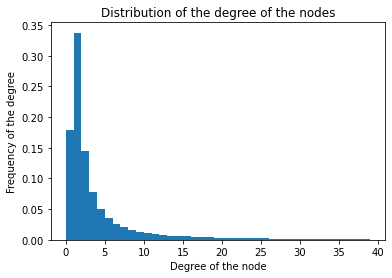

In [74]:
visualization1(data_a2q, data_c2a, data_c2q)

# Visualization 2

### Visualize the Best User

Use this function to check the importance, according to a metric, of a user of the graph restricted to a given time interval.

In [75]:
visualization2()

Input the beginning of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
15-1-2010
Input the end of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
17-1-2010
Choose one between the following metrics: 
1. Betweeness
2. PageRank
3. ClosenessCentrality
4. DegreeCentrality
4
Choose the user you want to apply the metric on: 20862


  4%|██▎                                                                | 590405/16703594 [00:00<00:05, 2989463.11it/s]

Loading the graph...


100%|█████████████████████████████████████████████████████████████████| 13664641/13664641 [00:04<00:00, 3091533.18it/s]


The degree centrality for the given node is: 0.018008612814824482


In [76]:
visualization2()

Input the beginning of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
15-1-2010
Input the end of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
17-1-2010
Choose one between the following metrics: 
1. Betweeness
2. PageRank
3. ClosenessCentrality
4. DegreeCentrality
2
Choose the user you want to apply the metric on: 20862


  4%|██▎                                                                | 589274/16703594 [00:00<00:05, 2983857.54it/s]

Loading the graph...


100%|█████████████████████████████████████████████████████████████████| 13664641/13664641 [00:04<00:00, 3117047.05it/s]


The page rank for the given node is: 0.002793078708743579


In [89]:
visualization2()

Input the beginning of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
15-8-2010
Input the end of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
15-8-2010
Choose one between the following metrics: 
1. Betweeness
2. PageRank
3. ClosenessCentrality
4. DegreeCentrality
3
Choose the user you want to apply the metric on: 345383


  4%|██▎                                                                | 591417/16703594 [00:00<00:05, 2996131.84it/s]

Loading the graph...


100%|██████████████████████████████████████████████████████████████████████████████| 2855/2855 [20:50<00:00,  2.28it/s]

The closeness centrality for the given node is: 0.8537241998205205


# Visualization 3
### Visualize the Shortest Ordered Route
Use this function to see the shortest ordered route passing for some given nodes in a merged graph restricted to a given time interval.

In [72]:
visualization3()

Input the beginning of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
15-1-2010
Input the end of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
16-1-2010
Input all the nodes in sequence (note: the nodes are integers, input anything else to stop adding nodes)
Insert the first node: 54197
Insert the next node: 48465
Insert the next node: 234499
Insert the next node: end


  4%|██▍                                                                | 595299/16703594 [00:00<00:05, 3017717.43it/s]

Calculating the shortest ordered route: 
Loading the graph...


100%|█████████████████████████████████████████████████████████████████| 13664641/13664641 [00:04<00:00, 3091390.27it/s]


The shortest path passing in all given nodes is [54197, 63627, 97614, 48465, 84206, 234499] with a distance of 2.5


# Visualization 4

### Visualize disconnecting graphs

Use this function to see how many links are required to disconnect two given users.

In [79]:
visualization4()

Input the beginning of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
15-1-2010
Input the end of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): 
17-1-2010
Enter the nodes that you want to disconnect: 
Enter the first node: 234499
Enter the second node: 54197


100%|█████████████████████████████████████████████████████████████████| 13664641/13664641 [00:04<00:00, 3103830.52it/s]


To disconnect the two nodes we needed 3 cuts.
These were the edges of the graph that were cut: [[[234499, 242182], [234499, 206328]], [[54197, 63627]]]


### Backend Functionality

In this section we put all the function we used for the visualization part, to give a better explanation of some choices and making the code more visible

#### Dataset Preparing

The first three function are designed to extract the information from the *txt files* into 3 different Pandas dataframe and create a graph from them. As mentioned before we decided to drop all the lines where we had the same Source and Target so all self-referencing edges. The function **create_graph** create graphs from a single Pandas dataframe while **merge_graph** merge the 3 different graphs. Both take as input a time interval to filter the dataframe and construct the graph only with the nodes corresponding to it.


In [6]:
def prepare_datasets():
    
    data_a2q = pd.read_csv('data/sx-stackoverflow-a2q.txt', delimiter = ' ', names=['Source','Target','Time'])
    data_c2a = pd.read_csv('data/sx-stackoverflow-c2a.txt', delimiter = ' ', names=['Source','Target','Time'])
    data_c2q = pd.read_csv('data/sx-stackoverflow-c2q.txt', delimiter = ' ', names=['Source','Target','Time'])
    
    data_a2q['Time']=pd.to_datetime(data_a2q['Time'], unit='s').dt.date
    data_c2a['Time']=pd.to_datetime(data_c2a['Time'], unit='s').dt.date
    data_c2q['Time']=pd.to_datetime(data_c2q['Time'], unit='s').dt.date
     
    data_a2q = data_a2q[data_a2q['Source'] != data_a2q['Target']]
    data_c2a = data_c2a[data_c2a['Source'] != data_c2a['Target']]
    data_c2q = data_c2q[data_c2q['Source'] != data_c2q['Target']]
    
    
    return data_a2q, data_c2a, data_c2q

In [7]:
def create_graph(dataset,weight, time_interval = [dt.strptime('1-1-2000', "%d-%m-%Y").date(),dt.strptime('31-1-2021', "%d-%m-%Y").date()]):
    
    source = dataset['Source'].values
    target = dataset['Target'].values
    time = dataset['Time'].values
    
    start = time_interval[0]
    end = time_interval[1]
    G = nx.DiGraph()    
    
    for i in tqdm(range(len(source))):
        if start <= time[i] <= end:
            if source[i] != target[i]:#check if edge is not self referencing
                if (source[i], target[i]) in G.edges():
                    G[source[i]][ target[i]]['weight'] += weight
                else:
                    G.add_edge(source[i],target[i], weight = weight)
    
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1 / G[edge[0]][edge[1]]['weight']
        
    return G

In [8]:
def merge_graph(time_interval = [dt.strptime('1-1-2000', "%d-%m-%Y").date(),dt.strptime('31-1-2021', "%d-%m-%Y").date()]):   
    
    G_a2q = create_graph(data_a2q, weight = 2, time_interval = time_interval)
    G_c2a = create_graph(data_c2a, weight = 1, time_interval = time_interval)
    G_c2q = create_graph(data_c2q, weight = 1, time_interval = time_interval)    
    
    #create a copy of first graph
    G = G_a2q.copy()
    
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1 / G[edge[0]][edge[1]]['weight']
    
    #add edges of second graph
    for edge in G_c2a.edges:
        if (edge[0], edge[1]) in G.edges():
            G[edge[0]][edge[1]]['weight'] +=1
        else:
            G.add_edge(edge[0],edge[1], weight = 1)
            
    #add edges of third graph
    for edge in G_c2a.edges:
        if (edge[0], edge[1]) in G.edges():
            G[edge[0]][edge[1]]['weight'] +=1
        else:
            G.add_edge(edge[0],edge[1], weight = 1)
            
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1 / G[edge[0]][edge[1]]['weight']
        
    return G

##### Functionality 1

We used a single function to get the basic informations of a graph. First we check if it is directed, and to do this we check, for any edge in the graph, there is his opposite version too. If there is at least one edge where this doesn't hold than we can conclude that the graph is directed. Then for the number of users and number of answers/comments we simply count the number of nodes and edges respectively, and calculate their ratio to check the average number of links per user. For the density degree of the graph we simply check if the graph is directed or not and use the appropiate formula. In particular we have that:
$D=\frac{2|E|}{|V|(|V|-1)}$ if the graph is undirected;      $D=\frac{|E|}{|V|(|V|-1)}$ if the graph is directed.
Here |E| and |V| represent the number of edges and vertices in the graph. 
Lastly we decided to plot an histogram of the destribution of the degree of the nodes of the graph.

In [73]:
def graphInfo(graph):
    
    # 1. Whether the graph is directed or not
    
    # I assume that the graph is undirected so I initialize my variable as False.
    d = False
    # For each couple 
    for couple in graph.edges():
        if (couple[1],couple[0]) not in graph.edges():
            d = True
            break
            
    # I print the output based on the previous results.       
    if d == True:
        print('The graph is directed')
    else:
        print('The graph is undirected')
        
    # 2. Number of users

    
    print('The number of users is: ', len(graph.nodes))
    
    # Number of interactions
    
    print(f"The number of total interactions is: {len(graph.edges())}")
    
    # 3. Average number of links per user
    
    # I initialize an empty string in order to insert into it the nodes (users)

    
    print(f'The average number of links per user is {len(graph.edges())/len(graph.nodes)}')
    
    # 4. Density degree of the graph
    
    if d == False:
        g_density = 2*len(graph.nodes)/(len(graph.edges())*(len(graph.edges())-1))
        print(f"The graph density is: ", g_density)
    if d == True:
        g_density = len(graph.nodes)/(len(graph.edges())*(len(graph.edges())-1))
        print(f"The graph density is: ", g_density)
    
   # 5. Whether the graph is sparse or dense
      # Dense graph is a graph in which the number of edges is close to the maximal number of edges. 
      # Sparse graph is a graph in which the number of edges is close to the minimal number of edges.
    max_edges = len(graph.edges())*len(graph.edges())/2
    
    is_sparse = g_density <= 0.5
    
    if is_sparse:
        print("The graph is sparse")
    else:
        print("The graph is dense")
    
    
    # Plot of the distribution of the node's degree of the graph
    
    degrees = []
    for node in graph.nodes:
        degrees.append(len([n for n in graph[node]]))
    plt.hist(degrees, bins = range(0,40,1), density = True)
    plt.title('Distribution of the degree of the nodes')
    plt.xlabel('Degree of the node')
    plt.ylabel('Frequency of the degree')

##### Functionality 2
For each metric we defined a single function and the gathered them together in the **applyMetric** which select which one to use. To define the **Degree Centrality** we simply use the formula $DC(V)=\frac{d_{V}}{|V|-1}$ where $d_{V}$ is the degree of the node, so the number of edges adjacent to it. For the **Closeness Centrality** we calculate every shortest path connecting the node to every other node using the **Dijkstra's Algorithm** and use the formula $C(x) = \sum_{y\neq x} \frac {|V|}{d(x,y)}$.
For the **Page Rank** algorithm we used as a reference [this website](https://www.geeksforgeeks.org/page-rank-algorithm-implementation/).


In [10]:
def applyMetric(time_interval, metric, starting_user):
    print("Loading the graph...")
    G = merge_graph(time_interval)
    if int(metric) == 1:
        print(f"The betweeness centrality for the given node is: {betweenessCentrality(G, starting_user)}")
    elif int(metric) == 2:
        print(f"The page rank for the given node is: {pageRank(G)[starting_user]}")
    elif int(metric) == 3:
        print(f"The closeness centrality for the given node is: {closenessCentrality(G, starting_user)}")
    elif int(metric) == 4:
        print(f"The degree centrality for the given node is: {degreeCentrality(G, starting_user)}")

In [11]:
def degreeCentrality(G, user):
    node_degree = 0
    for edge in G.edges():
        if edge[0] == user or edge[1] == user:
            node_degree += 1
    return node_degree / (len(G)-1)

In [12]:
def closenessCentrality(G,user):
    result = 0
    for node in tqdm(G.nodes):
        distance, path = dijkstraAlgo(G, user, node)
        if distance!='Not possible':
            result += distance
    if result != 0:
        return (len(G)-1)/result
    return("The given node isn't connected to anything")

In [13]:
#https://www.geeksforgeeks.org/page-rank-algorithm-implementation/
def pageRank(G, alpha=0.85, personalization=None,
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight',
             dangling=None):
 
    # Create a copy in (right) stochastic form
    D=G
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()
 
    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = float(sum(nstart.values()))
        x = dict((k, v / s) for k, v in nstart.items())
 
    if personalization is None:
 
        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(personalization.values()))
        p = dict((k, v / s) for k, v in personalization.items())
 
    if dangling is None:
 
        # Use personalization vector if dangling vector not specified
        dangling_weights = p
    else:
        missing = set(G) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(dangling.values()))
        dangling_weights = dict((k, v/s) for k, v in dangling.items())
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]
 
    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
 
            # this matrix multiply looks odd because it is
            # doing a left multiply x^T=xlast^T*W
            for nbr in W[n]:
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]
 
        # check convergence, l1 norm
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < N*tol:
            return x
    raise ('pagerank: power iteration failed to converge ')

##### Functionality 3

For this part we use two functions. In **dijkstraAlgo** there is our implementation of the [Dijkstra's Algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm). Then in **shortest_ordered_route** there is the implementation of the functionality 3. To get the shortest route passing for all the given points $[p_{1}, p_{2},\dots , p_{n}]$ we use the Algorithm between $p_{1}$ and $p_{2}$, then between $p_{2}$ and $p_{3}$ and so on and connect all the resulting path to obtain the final result.

In [14]:
def shortest_ordered_route(time_interval, sequence_of_users):
    print("Loading the graph...")
    G = merge_graph(time_interval)
    totalDistance = 0
    finalPath = []
    for i in range(len(sequence_of_users)-1):
        distance, path = dijkstraAlgo(G,sequence_of_users[i], sequence_of_users[i+1])
        if distance == 'Not possible':
            return("It isn't possible to find a path between these nodes")
        totalDistance += distance
        if path != False:
            for i in range(len(path)-1):
                finalPath.append(path[i])
    finalPath.append(sequence_of_users[-1])
    return(f"The shortest path passing in all given nodes is {finalPath} with a distance of {totalDistance}")

In [86]:
def dijkstraAlgo(G, source, target):
    distances  = {} 
    previous_nodes = {} 
    unvisited_nodes = list(nx.nodes(G)) 
    if (source not in list(G.nodes)) or (target not in list(G.nodes)):
        return ('Not possible', None)
    
    #setting all distances to +inf and the distance of the source node to 0
    for node in unvisited_nodes:
        distances[node] = math.inf
        previous_nodes[node] = None
    distances[source] = 0 
     
    while len(unvisited_nodes) > 0:#until I visit all possible nodes 
        node_distance = []
        for node in unvisited_nodes: 
            node_distance.append(distances[node])
        if np.min(node_distance) == math.inf:   #if all the distances are infinite it means I can't reach those nodes
            break
        u = unvisited_nodes[node_distance.index(np.min(node_distance))] #I take the unvisited node with less distance
        unvisited_nodes.remove(u) 
        
        
        for neighbor in G.neighbors(u):  #I check his neighbors
            new_dist = distances[u] + G[u][neighbor]['weight']  
            if distances[neighbor] > new_dist:  #update the distance only if it is smaller
                distances[neighbor] = new_dist 
                previous_nodes[neighbor] = u

               
                
    if previous_nodes[target] == None:  #If I didn't reach the target there aren't any path to it so I exit the function
        return ('Not possible', None)

    path = [target]
    current = target
    while current != source:   #From the target I get back to the source using the previous_nodes dictionary
        path.append(previous_nodes[current])
        current = previous_nodes[current]
    path.reverse()

    return distances[target], path

##### Functionality 4

In this task we had to separate two given nodes so that there isn't any path connecting one to another. To do this we use our **Dijkstra'a Algorithm** to check if there is a path connecting them. If there is a path we cut the edge with less weight and try again the algorithm until we can't find a new path. Since this is a directed graph it is possible that a node A isn't connected to a node B but B is connected to A, so we had to make sure we applied the algorithm both ways. Our function gives in output the number of cuts we performed and what edges we removed.

In [16]:
def disconnectNodes(G, node1, node2):    
    numberOfDisconnection = 0
    edgeDisconnected = []
    distance, path = dijkstraAlgo(G, node1, node2)
    
    if distance == 'Not possible':#I check if the nodes are already disconnected
        return(numberOfDisconnection, edgeDisconnected)

    while distance!= 'Not possible':#I repeate until the nodes are disconnected
        weights = []  #I save all the weight of the single edges of the path so that I can remove the minimum
        for i in range(len(path)-1):
            weights.append(G[path[i]][path[i+1]]['weight'])
        cut_index = weights.index(min(weights))  #Find the index where I have to cut
        G.remove_edge(path[cut_index],path[cut_index+1])  #Remove the edge from the graph and save its information in our vector
        numberOfDisconnection +=1
        edgeDisconnected.append([path[cut_index],path[cut_index+1]])
        distance, path = dijkstraAlgo(G, node1, node2)  #Check dijkstra again to see if they're disconnected or not
    
    return numberOfDisconnection, edgeDisconnected   

In [17]:
def disconnectGraph(time_interval, user1, user2):
    disconnection = 0
    edgeDisconnected = []
    G = merge_graph(time_interval)
    
    #first disconnect user1 from user 2
    firstDisconnection, firstEdges = disconnectNodes(G, user1, user2)
    disconnection += firstDisconnection    
    edgeDisconnected.append(firstEdges)
    
    #then disconnect user 2 from user 1
    
    secondDisconnection, secondEdges = disconnectNodes(G, user2, user1)
    disconnection += secondDisconnection    
    edgeDisconnected.append(secondEdges)
    
    return disconnection, edgeDisconnected
    
    

In [80]:
time_interval = [dt.strptime('15-8-2010', "%d-%m-%Y").date(),dt.strptime('15-8-2010', "%d-%m-%Y").date()]

In [81]:
G = merge_graph(time_interval)

100%|█████████████████████████████████████████████████████████████████| 13664641/13664641 [00:04<00:00, 3121932.89it/s]


In [33]:
G_a2q=create_graph(data_a2q, weight = 2, time_interval = time_interval)


100%|█████████████████████████████████████████████████████████████████| 16703594/16703594 [00:05<00:00, 3101936.55it/s]


In [85]:
G.nodes

NodeView((345383, 420493, 330565, 25999, 420451, 344286, 203459, 398262, 268874, 343088, 183528, 188962, 388299, 242763, 313137, 419275, 340355, 383187, 53797, 394649, 2147, 2847, 251461, 29110, 420346, 420301, 420415, 394305, 98180, 299935, 111445, 186636, 385953, 5834, 420506, 134397, 234661, 63264, 420375, 50175, 246568, 288875, 407573, 83037, 232371, 420444, 257535, 369317, 401120, 420508, 112355, 414972, 125075, 65084, 357234, 210905, 413897, 417024, 166067, 419240, 238489, 383402, 420512, 203907, 87399, 325565, 408894, 215534, 185848, 127359, 390695, 336508, 208222, 294650, 418488, 70613, 157882, 259014, 247243, 148870, 417854, 411500, 11470, 366209, 229602, 14800, 179795, 310574, 22656, 2034126, 19299, 388553, 66692, 401523, 102207, 203476, 420505, 236532, 5921, 415540, 20860, 204588, 312627, 191808, 420521, 420433, 358202, 420517, 312260, 3397, 224671, 407060, 411802, 187606, 1762, 420344, 398749, 15255, 88159, 140814, 189294, 295264, 118272, 3713, 287885, 190597, 420501, 44532

In [ ]:
closenessCentrality(G, 345383)

In [62]:
54197  230202  63627  48465  84206 251111  84206  234499   

SyntaxError: invalid syntax (<ipython-input-62-4992d226f45c>, line 1)

In [46]:
degreeCentrality(G,20862)

0.014790996784565916

In [47]:
pageRank(G)[20862]

0.0021602548844664605

In [48]:
closenessCentrality(G,20862)

  0%|▏                                                                             | 13/4666 [00:19<1:55:59,  1.50s/it]


KeyboardInterrupt: 

##### Visualization 
Here we store all the function we used to make the Visualization part which takes inputs from the user

In [27]:
def visualization1(data_a2q, data_c2a, data_c2q):
    print("Select the dataset you want to have some information about:")
    print("1. Answers to questions \n2. Comments to answers \n3. Comments to questions \n")
    n = int(input())
    if n not in [1,2,3]:
        print("Unexpected input")
        return visualization1()
    
    if n == 1:
        print("Please wait...")
        G = create_graph(data_a2q, weight = 2)
        graphInfo(G)
    elif n == 2:
        print("Please wait...")
        G = create_graph(data_c2a, weight = 2)
        graphInfo(G)
    elif n == 3:
        print("Please wait...")
        G = create_graph(data_c2q, weight = 2)
        graphInfo(G)

In [28]:
def visualization2():
    print("Input the beginning of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): ")
    try:
        start = dt.strptime(input(), "%d-%m-%Y").date()
    except:
        print("Invalid date format")
        return visualization2()
        
    print("Input the end of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): ")
    try:
        end = dt.strptime(input(), "%d-%m-%Y").date()
    except:
        print("Invalid date format")
        return visualization2()
    time_interval = [start, end]
    metricNotChose = True
    print("Choose one between the following metrics: \n1. Betweeness\n2. PageRank\n3. ClosenessCentrality\n4. DegreeCentrality")
    while metricNotChose:
        n = int(input())
        if n in [1,2,3,4]:
            metricNotChose = False
        else:
            print("Choose a valid metric")
    user = int(input("Choose the user you want to apply the metric on: "))
    
    applyMetric(time_interval, n, user)

In [71]:
def visualization3():
    print("Input the beginning of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): ")
    try:
        start = dt.strptime(input(), "%d-%m-%Y").date()
    except:
        print("Invalid date format")
        return visualization3()
        
    print("Input the end of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): ")
    try:
        end = dt.strptime(input(), "%d-%m-%Y").date()
    except:
        print("Invalid date format")
        return visualization3()
    time_interval = [start, end]
    print("Input all the nodes in sequence (note: the nodes are integers, input anything else to stop adding nodes)")
    
    sequence = [int(input("Insert the first node: ")), int(input("Insert the next node: "))]
    
    continuing = True
    while continuing:
        try:
            n = int(input("Insert the next node: "))
            sequence.append(n)
        except:
            continuing = False
    
    print("Calculating the shortest ordered route: ")
    print(shortest_ordered_route(time_interval, sequence))

In [78]:
def visualization4():
    print("Input the beginning of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): ")
    try:
        start = dt.strptime(input(), "%d-%m-%Y").date()
    except:
        print("Invalid date format")
        return visualization4()
        
    print("Input the end of the time interval you want the graph to be restricted to (format: dd-mm-yyyy): ")
    try:
        end = dt.strptime(input(), "%d-%m-%Y").date()
    except:
        print("Invalid date format")
        return visualization4()
    time_interval = [start, end]
    
    print("Enter the nodes that you want to disconnect: ")
    node1 = int(input("Enter the first node: "))
    node2 = int(input("Enter the second node: "))
    
    n, edges = disconnectGraph(time_interval, node1, node2)
    
    if n==0:
        return("The two nodes are already disconnected")
    
    print(f"To disconnect the two nodes we needed {n} cuts.")
    print(f"These were the edges of the graph that were cut: {edges}")
    

In [31]:
def admat(G, v):
    # G is the graph
    # v is the nodes' vector
    mat = []
    for i in range(len(v)):
        l = []
        for j in range(len(v)):
            l.append(0)
        mat.append(l)

# I created a squared matrix of lenght equal to v's lenght

    for elem in v:  # key in v that is the label of a node

        if elem in G:
            i = velem  # I find the row that corresponds to the node 'elem'
            l = Gelem  # List of adjacency of 'elem'

            for node in l:
                j = vnode  # I find the row/column that corresponds to 'node'
                matj = 1
    return mat

def main(G, v):
    out = admat(G, v)
    print(out)

main(G_a2q, G_a2q.nodes())

def pr(G, node):
    
    # 'A' is the (directed) adjacency matrix
    A = main(G, v)
    A = np.array(A)
    
    # Add a self loop to each node that doesn't have an outgoing link
    for node in tqdm(G.nodes):
        for couple in graph.edges():
            if (couple[1],couple[0]) not in graph.edges():
                graph.add_edge(edge[0],edge[0], weight = 1)
        
        # Let D be the diagonal matrix of outdegrees
        D = G.outdegree()
        D = np.array(D)
        
        # Define a column stochastic matrix (columns add to 1) N = AD^(-1) 
        D = 1/D
        N = np.dot(A, D)
        
        # The PageRank Centrality of node i is equal to the leading eigenvector eigvecs
        # of matrix N (leading eigenvalue is 1): eigvecs = N*eigvecs
        eigvals, eigvecs = la.eig(A)
        print(eigvals)
        print(eigvecs, sum(eigvecs))
        
        # Notice that the underlying concept to the PageRank is that of a Markov chain where a user moves 
        # from one page to the other with a certain probability, 
        # given the presence of sinks (pages with no outgoing links) that is called a 
        # *damping factor* to represent the probability that a user at some point stops clicking,
        # preventing him from surely reaching a sink and getting stucked:
        
        alpha = 0.85
        pgr = D * (1/(D - (alpha * A)))
        return(pgr)

NameError: name 'G_a2q' is not defined